* Compare Distributed distributed representations of documents
    * BoW, tf-idf, Word2Vec(average), Doc2Vec, SCDV
* SCDV, See https://arxiv.org/abs/1612.06778

In [70]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import datasets, manifold, mixture
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.sport.baseball',
    'sci.space',
    'talk.politics.guns'
]
train = datasets.fetch_20newsgroups(subset='train', categories=categories)
valid = datasets.fetch_20newsgroups(subset='test', categories=categories)

train.data = np.array(train.data, dtype=np.object)
valid.data = np.array(valid.data, dtype=np.object)

In [5]:
len(train.data), len(train.target), len(valid.data), len(valid.target)

(2800, 2800, 1863, 1863)

In [6]:
for i, c in enumerate(categories):
    indices = np.where(train.target == i)
    print(c + ':\t{}'.format(len(train.data[indices])))

alt.atheism:	480
comp.graphics:	584
rec.sport.baseball:	597
sci.space:	593
talk.politics.guns:	546


In [7]:
# BoW, tf-idf, average Word2Vec, Doc2Vec, SCDV

features_num = 200
min_word_count = 10
context = 5
downsampling = 1e-3
epoch_num = 10

In [8]:
def analyzer(text):
    
    stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
    text = text.lower() # 小文字化
    text = text.replace('\n', '') # 改行削除
    text = text.replace('\t', '') # タブ削除
    text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text) # 記号をスペースに置き換え
    text = text.split(' ') # スペースで区切る
    
    words = []
    for word in text:
        if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None): # 数字が含まれるものは除外
            continue
        if word in stop_words: # ストップワードに含まれるものは除外
            continue
        if len(word) < 2: #  1文字、0文字（空文字）は除外
            continue
        words.append(word)
        
    return words

* BoW

In [14]:
corpus = train.data
count_vectorizer = CountVectorizer(analyzer=analyzer, min_df=min_word_count, binary=True)
bows = count_vectorizer.fit_transform(corpus)

In [15]:
tsne_bow = manifold.TSNE(n_components=2).fit_transform(bows.toarray())

In [28]:
df_tsne_bow = pd.DataFrame({
    'x': tsne_bow[:, 0],
    'y': tsne_bow[:, 1],
    'category': train.target,
})

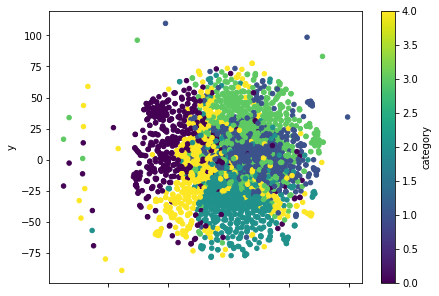

In [29]:
df_tsne_bow.plot.scatter(x='x', y='y', c='category', colormap='viridis', figsize=(7, 5), s=20)
plt.show()

* tf-idf

In [50]:
corpus = train.data
tfidf_vectorizer = TfidfVectorizer(analyzer=analyzer, min_df=min_word_count)
tfidfs = tfidf_vectorizer.fit_transform(corpus)

In [32]:
tsne_tfidf = manifold.TSNE(n_components=2).fit_transform(tfidfs.toarray())

In [33]:
df_tsne_tfidf = pd.DataFrame({
    'x': tsne_tfidf[:, 0],
    'y': tsne_tfidf[:, 1],
    'category': train.target,
})

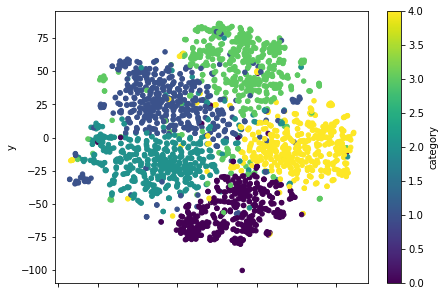

In [34]:
df_tsne_tfidf.plot.scatter(x='x', y='y', c='category', colormap='viridis', figsize=(7, 5), s=20)
plt.show()

* average Word2Vec

In [66]:
corpus = [analyzer(text) for text in train.data]
word2vecs = Word2Vec(
    sentences=corpus, iter=epoch_num, size=features_num,
    min_count=min_word_count, window=context, sample=downsampling,
)
avg_word2vec = np.array([word2vecs.wv[list(analyzer(text) & word2vecs.wv.vocab.keys())].mean(axis=0) for text in train.data])

In [42]:
tsne_avg_word2vec = manifold.TSNE(n_components=2).fit_transform(avg_word2vec)

In [43]:
df_tsne_avg_word2vec = pd.DataFrame({
    'x': tsne_avg_word2vec[:, 0],
    'y': tsne_avg_word2vec[:, 1],
    'category': train.target,
})

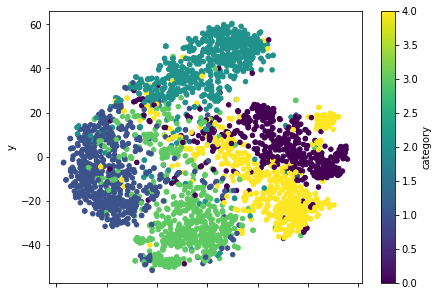

In [44]:
df_tsne_avg_word2vec.plot.scatter(x='x', y='y', c='category', colormap='viridis', figsize=(7, 5), s=20)
plt.show()

* Doc2Vec

In [92]:
corpus = [TaggedDocument(words=analyzer(text), tags=[i]) for i, text in enumerate(train.data)]
doc2vecs = Doc2Vec(
    documents=corpus, dm=1,  epochs=epoch_num, vector_size=features_num,
    min_count=min_word_count, window=context, sample=downsampling
) # dm == 1 -> dmpv, dm != 1 -> DBoW
doc2vecs = np.array([doc2vecs.infer_vector(analyzer(text)) for text in train.data])

In [93]:
tsne_doc2vec = manifold.TSNE(n_components=2).fit_transform(doc2vecs)

In [94]:
df_tsne_doc2vec = pd.DataFrame({
    'x': tsne_doc2vec[:, 0],
    'y': tsne_doc2vec[:, 1],
    'category': train.target,
})

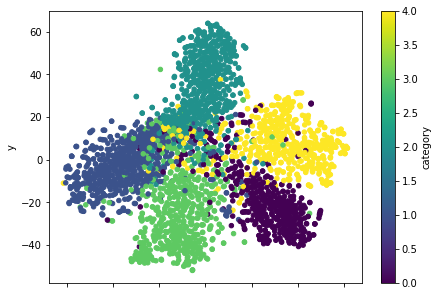

In [95]:
df_tsne_doc2vec.plot.scatter(x='x', y='y', c='category', colormap='viridis', figsize=(7, 5), s=20)
plt.show()

* SCDV-Word2Vec
* https://arxiv.org/abs/1612.06778

In [67]:
word_vectors = word2vecs.wv.vectors
clusters_num = 60
gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
gmm.fit(word_vectors)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=50,
        means_init=None, n_components=60, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [68]:
idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))

In [69]:
word_topic_vecs = {}
for word in assign_dic:
    word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
    for i in range(0, clusters_num):
        try:
            word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
        except:
            continue

In [53]:
scdvs = np.zeros((len(train.data), clusters_num*features_num), dtype=np.float32)

a_min = 0
a_max = 0

for i, text in enumerate(train.data):
    tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
    words = analyzer(text)
    for word in words:
        if word in word_topic_vecs:
            tmp += word_topic_vecs[word]
    norm = np.sqrt(np.sum(tmp**2))
    if norm > 0:
        tmp /= norm
    a_min += min(tmp)
    a_max += max(tmp)
    scdvs[i] = tmp

p = 0.04
a_min = a_min*1.0 / len(train.data)
a_max = a_max*1.0 / len(train.data)
thres = (abs(a_min)+abs(a_max)) / 2
thres *= p

scdvs[abs(scdvs) < thres] = 0
scdvs.shape

(2800, 12000)

In [54]:
tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)

In [55]:
df_tsne_scdv = pd.DataFrame({
    'x': tsne_scdv[:, 0],
    'y': tsne_scdv[:, 1],
    'category': train.target,
})

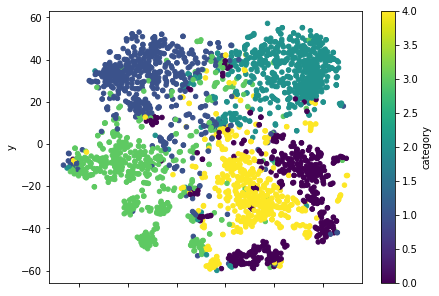

In [56]:
df_tsne_scdv.plot.scatter(x='x', y='y', c='category', colormap='viridis', figsize=(7, 5), s=20)
plt.show()